[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/simple-graph.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238187-lesson-2-simple-graph)

# 간단한 그래프

3개의 정점과 하나의 조건부 변을 가진 간단한 그래프를 만들어 보자.

![](https://i.imgur.com/mFFhK0D.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## State(상태)

먼저 그래프의 [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)를 정의합니다.

State 스키마는 그래프 내 모든 Nodes와 Edges의 입력 스키마 역할을 합니다.

키에 대한 타입 힌트를 제공하는 Python의 `typing` 모듈의 `TypedDict` 클래스를 스키마로 사용합니다.

In [ ]:
from typing import TypedDict

# State
class State(TypedDict):
  graph_state: str

## Nodes(노드)

[Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes)는 단순히 파이썬 함수입니다.

첫 번째 위치 인자는 위에서 정의한 State입니다.

State는 위에서 정의한 스키마를 가진 `TypedDict`이므로, 각 노드는 `state["graph_state"]`로 `graph_state` 키에 접근할 수 있습니다.

각 Nodes는 State 키 `graph_state`의 새 값을 반환합니다.

기본적으로 각 Nodes가 반환하는 새 값은 기존 State 값을 [덮어씁니다](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers).

In [ ]:
# Nodes
def node_1(state: State) -> State:
  print("--- Node 1 ---")
  return State(graph_state=state['graph_state'] + " I am")

def node_2(state: State) -> State:
  print("--- Node 2 ---")
  return State(graph_state=state['graph_state'] + " happy!")

def node_3(state: State) -> State:
  print("--- Node 3 ---")
  return State(graph_state=state['graph_state'] + " sad!")

## Edges(에지)

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges)는 Nodes를 연결합니다.

일반적인 Edges는 예를 들어 `node_1`에서 `node_2`로 항상 이동하고 싶을 때 사용합니다.

[조건부 에지(Conditional Edges)](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges)는 각 Nodes 간 경로를 _선택적으로_ 설정하고자 할 때 사용합니다.

조건부 에지는 특정 조건에 따라 다음 방문 Nodes를 반환하는 함수로 구현됩니다.

In [ ]:
from random import random 
from typing import Literal

# Conditional edge
def decide_mood(state: State) -> Literal["node_2", "node_3"]:
    if random() > 0.5:
        return "node_2"
    else:
        return "node_3"

## 그래프 생성

이제 위에서 정의한 [컴포넌트(components)](https://langchain-ai.github.io/langgraph/concepts/low_level/)로 그래프를 생성합니다.

[StateGraph 클래스](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph)는 사용할 수 있는 그래프 클래스입니다.

먼저, 위에서 정의한 State 클래스로 StateGraph 클래스를 초기화합니다.

그런 다음 Nodes와 Edges를 추가합니다.

그래스 시작 지점을 나타내기 위해 사용자 입력을 그래프로 보내는 특수 노드인 [`START` 노드](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node)를 사용합니다.

[`END` 노드](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node)는 종단 노드를 나타내는 특수 노드입니다.

마지막으로 그래프 구조에 대한 기본 검사를 수행하기 위해 [그래프를 컴파일](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph)합니다.

In [ ]:
from langgraph.graph import StateGraph, START, END

# Build Graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Compile
graph = builder.compile()

그래프를 [Mermaid 다이어그램](https://github.com/mermaid-js/mermaid)으로 시각화할 수 있습니다.

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	node_1(node_1)
	node_2(node_2)
	node_3(node_3)
	__end__([<p>__end__</p>]):::last
	__start__ --> node_1;
	node_1 -.-> node_2;
	node_1 -.-> node_3;
	node_2 --> __end__;
	node_3 --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



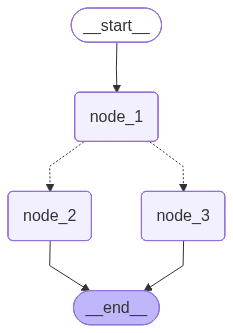

In [6]:
from IPython.display import display, Image

print(graph.get_graph().draw_mermaid())
display(Image(graph.get_graph().draw_mermaid_png()))

## 그래프 호출(Graph Invocation)

컴파일된 그래프는 [runnable](https://python.langchain.com/docs/concepts/runnables/) 프로토콜을 구현합니다.

이는 LangChain 컴포넌트를 실행하는 표준적인 방법을 제공합니다.

`invoke`는 이 인터페이스의 표준 메서드 중 하나입니다.

입력은 사전 `{"graph_state": "Hi, this is lance."}`로, 그래프 상태 사전의 초기값을 설정합니다.

`invoke`가 호출되면 그래프는 `START` 노드에서 실행을 시작합니다.

정의된 노드(`node_1`, `node_2`, `node_3`)를 순서대로 진행합니다.

조건부 에지는 50/50 결정 규칙을 사용하여 `node_1`에서 `node_2` 또는 `node_3`으로 이동합니다.

각 노드 함수는 현재 상태를 받아 새로운 값을 반환하며, 이 값은 그래프 상태의 기존 값을 덮어씁니다.

실행은 `END` 노드에 도달할 때까지 계속됩니다.

In [7]:
graph.invoke(State(graph_state="Hi, this is Lance."))

--- Node 1 ---
--- Node 3 ---


{'graph_state': 'Hi, this is Lance. I am sad!'}